In [29]:
# !pip install diffusers[torch] transformers scipy ftfy accelerate datasets --upgrade
# !pip install numpy==1.24.3


In [30]:
from datasets import load_dataset
imagenette = load_dataset('frgfm/imagenette',
                          'full_size',
                          split='train')
imagenette

Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

2


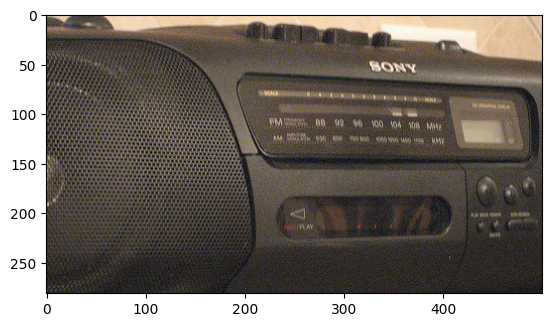

In [31]:
import matplotlib.pyplot as plt
plt.imshow(imagenette[0]['image'])
print(imagenette[0]['label'])

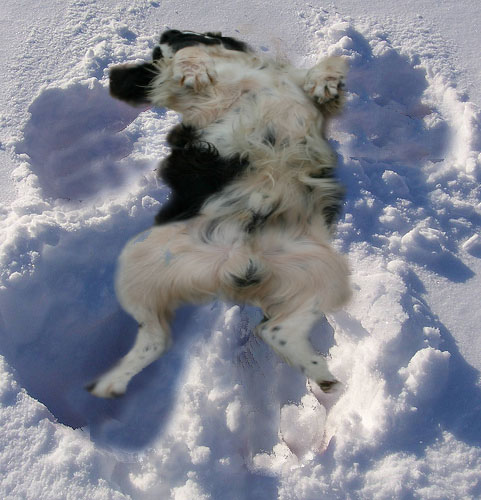

In [32]:
imagenette[6496]['image']

In [33]:
from transformers import CLIPTokenizerFast,CLIPProcessor, CLIPModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained(model_id).to(device)
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

In [34]:
prompt = "a dog in a snow"
# tokenize the prompt
inputs = tokenizer(prompt,return_tensors = "pt")
# inputs = inputs.to(device)
inputs


{'input_ids': tensor([[49406,   320,  1929,   530,   320,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [35]:
text_emb = model.get_text_features(**inputs)
text_emb.shape

torch.Size([1, 512])

In [36]:
image = processor(
    text=None,
    images=imagenette[0]['image'],
    return_tensors="pt"
)['pixel_values'].to(device)

image.shape


torch.Size([1, 3, 224, 224])

In [37]:
image.squeeze(0).T

tensor([[[ 1.7552,  1.4446,  1.0794],
         [ 1.7406,  1.4295,  1.0367],
         [ 1.6530,  1.3545,  0.9088],
         ...,
         [-1.4273, -1.3469, -1.2385],
         [-1.1353, -1.0918, -0.9399],
         [-0.9018, -0.8816, -0.7408]],

        [[ 1.7698,  1.3995,  1.1078],
         [ 1.7698,  1.4145,  1.0936],
         [ 1.6968,  1.3845,  0.9656],
         ...,
         [-1.3105, -1.1968, -1.0821],
         [-1.3251, -1.2268, -1.1532],
         [-1.2667, -1.1818, -1.0252]],

        [[ 1.8135,  1.5046,  1.1078],
         [ 1.7406,  1.4295,  1.0367],
         [ 1.6968,  1.3845,  0.9799],
         ...,
         [-1.2667, -1.2418, -0.9114],
         [-1.3251, -1.2268, -1.2385],
         [-1.3251, -1.1818, -1.2243]],

        ...,

        [[ 1.6968,  1.2945,  1.0083],
         [ 1.6384,  1.2945,  0.7239],
         [ 1.6384,  1.2795,  0.7666],
         ...,
         [-1.1353, -1.1368, -0.8545],
         [-1.2667, -1.1668, -1.0536],
         [-1.1499, -1.1068, -1.0536]],

        [[

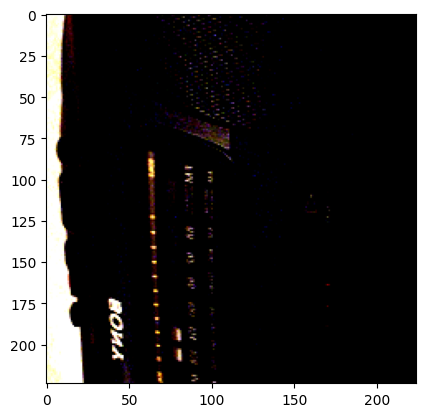

In [38]:
plt.imshow(image.squeeze(0).T)

In [39]:
image_emb = model.get_image_features(image)
image_emb.shape

torch.Size([1, 512])

In [40]:
import numpy as np

np.random.seed(0)
sample_idx = np.random.randint(0,len (imagenette) + 1,100).tolist()
# sample_idx
images = [imagenette[i]['image'] for i in sample_idx]
len(images)

100

In [41]:
from tqdm.auto import tqdm

batch_size = 16
image_arr = None

for i in tqdm(range(0,len(images),batch_size)):
    batch = images[i:i + batch_size]
    batches = processor(text=None,
                        images=batch,
                        return_tensors='pt',
                        padding=True)['pixel_values'].to(device)
    # get image embeddings
    batch_emb = model.get_image_features(pixel_values=batches)
    batch_emb = batch_emb.squeeze(0)
    # add to larger array of all image embeddings
    batch_emb = batch_emb.detach().cpu().numpy()
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr,batch_emb),axis=0)


# print(image.shape)

  0%|          | 0/7 [00:00<?, ?it/s]

In [42]:
print(image_arr.shape)

(100, 512)


# Text to image similarity search

In [43]:
image_arr.min(),image_arr.max()

(-7.9949155, 3.152508)

In [44]:
np.linalg.norm(image_arr,axis=1)

array([10.247569 ,  9.964737 , 11.059094 , 10.118765 ,  9.992206 ,
       10.428244 , 10.652135 ,  9.463356 , 10.08642  ,  9.9483   ,
       10.17383  , 10.329466 ,  9.745791 ,  9.666177 , 10.680568 ,
       10.100542 , 10.220927 , 10.739236 , 10.244998 , 10.325847 ,
       10.276642 , 10.602598 , 11.105055 ,  9.508577 , 10.006967 ,
       11.087345 , 10.216006 , 10.44699  , 11.129294 , 10.728575 ,
       10.130991 ,  9.9288435,  9.514743 ,  9.472759 , 10.19562  ,
       10.408339 , 10.207874 , 11.037595 ,  9.664329 ,  9.956552 ,
       11.234261 ,  9.771471 , 10.949164 , 10.07922  , 11.475828 ,
       10.012731 ,  9.851543 , 10.202886 ,  9.634335 , 10.108087 ,
       10.457738 , 10.896142 , 10.807462 , 11.264648 , 10.339072 ,
       10.147962 ,  9.197554 , 11.288829 , 10.431576 , 10.495576 ,
        9.561532 , 11.195873 ,  9.637506 ,  9.304305 ,  9.888565 ,
       10.321535 , 10.117645 , 11.530215 ,  9.496585 , 10.531773 ,
       10.9963875, 10.348045 ,  9.560839 , 10.688082 , 11.4504

# Apply L2 normalization

In [45]:
image_arr = image_arr.T/np.linalg.norm(image_arr,axis=1)


In [46]:
print(image_arr.shape)
image_arr = image_arr.T
image_arr.shape

(512, 100)


(100, 512)

In [47]:
image_arr.min(),image_arr.max()

(-0.69967157, 0.31254974)

In [48]:
text_emb = text_emb.cpu().detach().numpy()
print(text_emb)

[[-8.92895982e-02  7.56662488e-02 -2.53088236e-01  1.64394185e-01
  -1.08306199e-01 -1.75689608e-01 -8.31606388e-02 -4.03578818e-01
  -1.12305820e-01  1.49300665e-01 -3.93655598e-01 -3.73003222e-02
   1.06357753e-01  4.25555706e-02  3.20239216e-01  3.12657543e-02
   5.00989594e-02 -2.08326522e-02 -1.38282686e-01 -5.83781116e-03
  -1.39620006e-01  1.13698402e-02  2.06998006e-01 -6.32216483e-02
   3.11135262e-01  2.44389981e-01  3.53658944e-01  2.43282899e-01
  -1.08966291e-01 -2.48448536e-01  1.44078180e-01 -6.32415712e-02
   1.86728418e-01  6.28754720e-02 -9.93574113e-02 -6.90727308e-03
  -2.50092387e-01  7.71856755e-02 -9.16927680e-02  1.48685738e-01
  -1.33140400e-01  3.92605335e-01  1.32628947e-01  1.92637682e-01
   2.13051587e-01  8.38861465e-02 -3.68170619e-01 -2.84071863e-01
   2.58799344e-01  1.74337298e-01  2.08231822e-01 -1.18399687e-01
  -1.11548975e-01  2.02703565e-01  4.52873826e-01 -3.53797942e-01
   3.43579412e-01  2.89525747e-01 -3.64850014e-01 -1.95993274e-01
  -9.65436

# We want find the similarity score between image embeddings and text embeddings

In [50]:
scores = np.dot(text_emb,image_arr.T)
scores.shape

(1, 100)

In [51]:
scores[0].shape

(100,)

In [52]:
top_k = 5
idx = np.argsort(-scores[0])[:top_k]
idx

array([71, 24, 86, 76, 42])

2.4248347


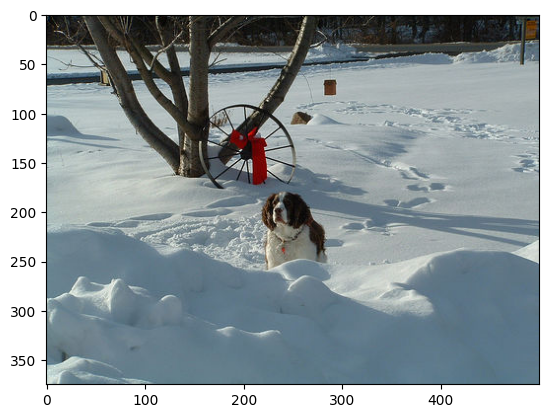

2.1998467


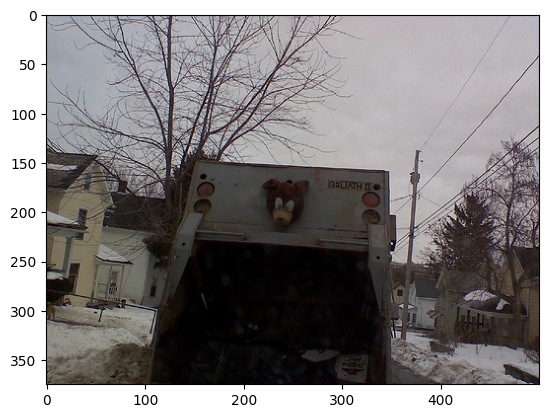

1.824753


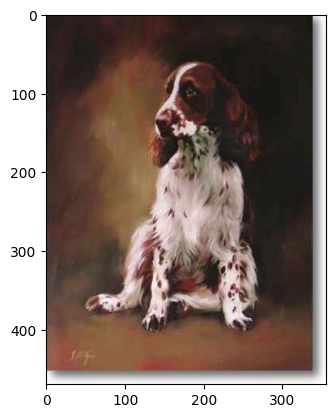

1.7624345


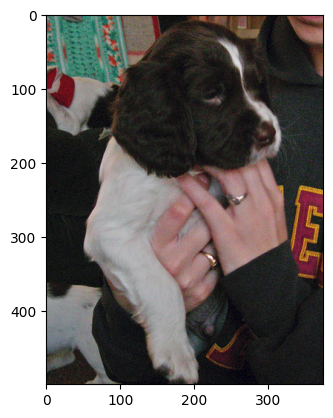

1.7324457


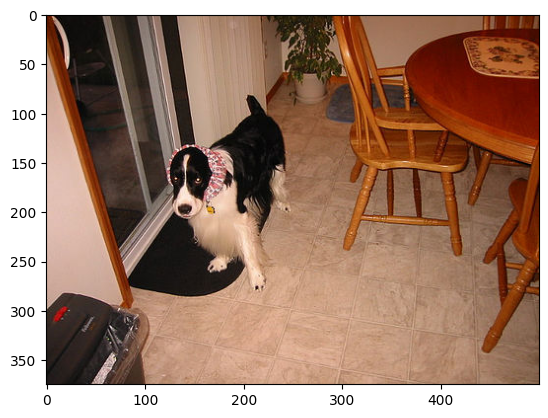

In [53]:
for i in idx:
    print(scores[0][i])
    plt.imshow(images[i])
    plt.show()